# Mapping our studies

Now that we have linked our studies to grid cells, we can plot the density of studies per grid cell on a map

In [6]:
import pandas as pd
import re
import os

# First we load the data and the predictions
from D_run_cv_experiments import load_data
df = load_data(False)

# Now we get the predictions, and filter only those likely to be relevant
df = df.merge(pd.read_csv('cv_data/INCLUDE/predictions_2_splits.csv'), how="outer")
df = df[(df["INCLUDE"]==1) | (df["prediction"]>=0.5)]
print(df.shape)
df.head()

(1344, 16)


,id,abstract,title,seen,INCLUDE,12 - Coastal and marine Ecosystems,12 - Human and managed,"12 - Mountains, snow and ice","12 - Rivers, lakes, and soil moisture",12 - Terrestrial ES,title_lcase,OA_id,doi,publication_year,authors,prediction
2,1293885.0,Climate change has a strong impact on vegetati...,Spatial and temporal changes of spring tempera...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,spatialandtemporalchangesofspringtemperatureth...,NaN,NaN,NaN,NaN,NaN
4,509759.0,"Up to present, research relating environmental...",Where the rain falls: Evidence from 8 countrie...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,wheretherainfallsevidencefrom8countriesonhowvu...,NaN,NaN,NaN,NaN,NaN
5,1705692.0,It is widely accepted that the Earth's climate...,Climate Variability and Malaria Incidence: Imp...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,climatevariabilityandmalariaincidenceimpactand...,NaN,NaN,NaN,NaN,NaN
10,3981306.0,Cool-season (April to October) rainfall domina...,The impact of anthropogenic forcing and natura...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,theimpactofanthropogenicforcingandnaturalproce...,NaN,NaN,NaN,NaN,NaN
12,242928.0,Snow is an important environmental factor in a...,Winter climate change in alpine tundra: plant ...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,winterclimatechangeinalpinetundraplantresponse...,NaN,NaN,NaN,NaN,NaN


In [17]:
# Now we load our index of studies to grid cells, and generate a column which for each document-place combo is
# 1 / the number of grid cells it appears in 
shp_df_matches = pd.read_csv("data/shp_df_matches.csv")
shp_df_matches["doc_share"] = shp_df_matches.groupby("doc_id")["grid_df_id"].transform(
    lambda x: 1 / x.shape[0]
)


In [18]:
grid_df = pd.read_csv('data/grid_df.csv')

# Here we define a function that takes a dataframe and returns a grid cell dataframe with the weighted 
# number of studies from that dataframe in each cell
def sum_studies(df, shp_df_matches, grid_df):
    sums = (shp_df_matches[shp_df_matches["doc_id"].isin(df["id"])]
     .groupby("grid_df_id")["doc_share"].sum()
    ).to_frame("n").reset_index().rename(columns={"grid_df_id": "index"})

    return grid_df.merge(sums, how="outer")

study_grid_df = sum_studies(df, shp_df_matches, grid_df)


/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/max/software/py39/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


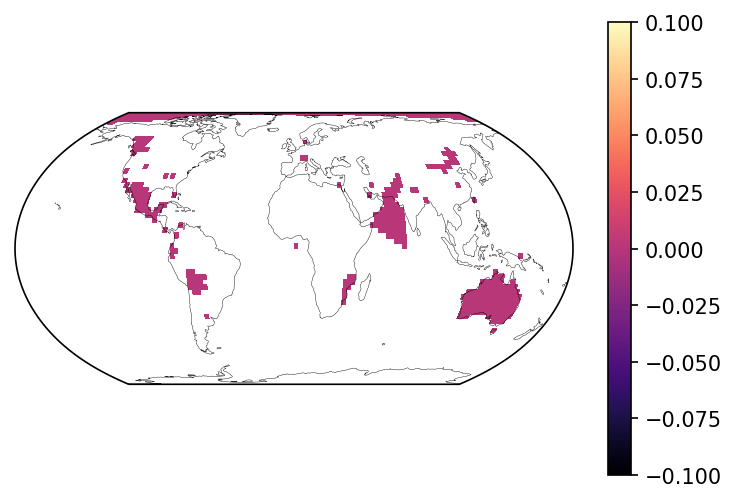

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection=ccrs.EqualEarth())
ax.coastlines(lw=0.2)

shape = (len(study_grid_df.LAT.unique()), len(study_grid_df.LON.unique()))

n = np.array(study_grid_df.n).reshape(shape)

mesh=ax.pcolormesh(
    study_grid_df.LON.unique(), 
    study_grid_df.LAT.unique(), 
    n, 
    cmap=plt.cm.get_cmap('magma'),
    #norm=mpl.colors.LogNorm(),
    #vmin=1,
    transform=ccrs.PlateCarree(),
)

cbar = plt.colorbar(mesh)